In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import itertools as it
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
import multipoles
import ellisbaldwin
from qso_sample import QSOSample
import dipole

### load samples

In [3]:
# instantiate dipole object:
catdir = '/scratch/aew492/quasars/catalogs'
mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')

d = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
              mask_fn=mask_fn,
              mag='g', maglim=20.,
              blim=30)
d.cut_galactic_plane()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_quaia = ellisbaldwin.compute_expected_dipole_gaia(d.table, maglimit=d.maglim,
                                                            min_g=19.5, max_g=20.5)
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

# at the healpix level:

# load selection function
selfunc_quaia = d.get_selfunc(os.path.join(catdir, 'quaia/selfuncs',
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}_blim15.fits')) # note the blim15 !
# get masked datamap
masked_datamap = d.construct_masked_datamap(selfunc=selfunc_quaia, return_map=True)
mu = np.nanmean(masked_datamap)
print(f"mean density in the masked map = {mu:.2f} quasars per healpixel", flush=True)

# overdensity map, corrected by selection function
overdensity_map = d.construct_overdensity_map(selfunc=selfunc_quaia, min_completeness=0.)

loading initial catalog, /scratch/aew492/quasars/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 30 -> 917566 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.309
	effective alpha = 0.713
	expected dipole amplitude = 0.0052
cut G > 20.0 -> 530364 sources left.
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.0
mean density in the masked map = 33.50 quasars per healpixel
constructing overdensity map


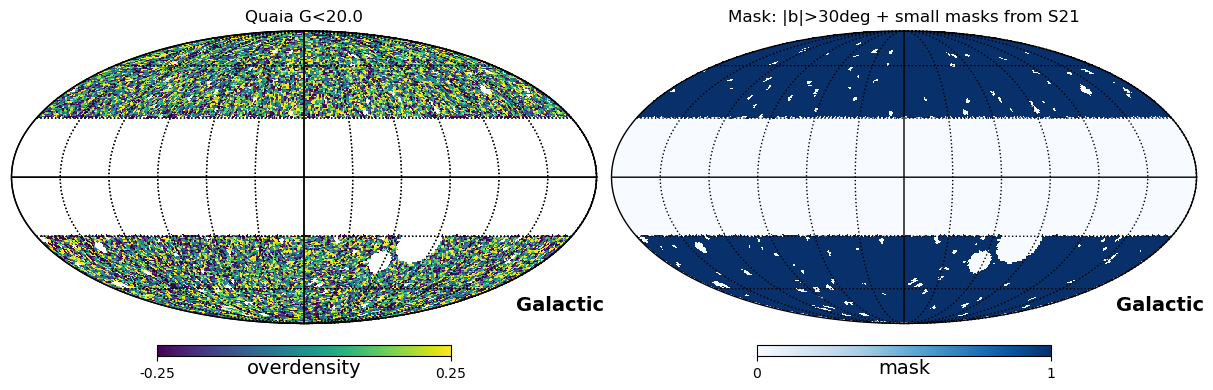

In [4]:
# plot overdensity map
fig = plt.figure(figsize=(12,4))
hp.mollview(overdensity_map, coord=['C','G'], min=-0.25, max=0.25, unit='overdensity', title=f'Quaia G<{d.maglim}', badcolor='w',
            fig=fig, sub=(1,2,1))
hp.graticule()
hp.mollview(d.mask, coord=['C','G'], min=0, max=1, unit='mask', title=f'Mask: |b|>{d.blim}deg + small masks from S21',
            cmap='Blues', fig=fig, sub=(1,2,2))
hp.graticule()

### angular power measured with different regularization strengths $\Lambda$

In [5]:
# inputs
Lambdas = np.logspace(-5, 1, 11)
max_ell = 5

In [6]:
# measure the Cells from the overdensity map:
Cells = np.empty((len(Lambdas), max_ell))
for i, Lambda in enumerate(Lambdas):
    ells_, Cells_ = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map, Lambda=Lambda,
                                                             max_ell=max_ell, selfunc=selfunc_quaia)
    Cells[i] = Cells_[1:]
ells = ells_[1:]

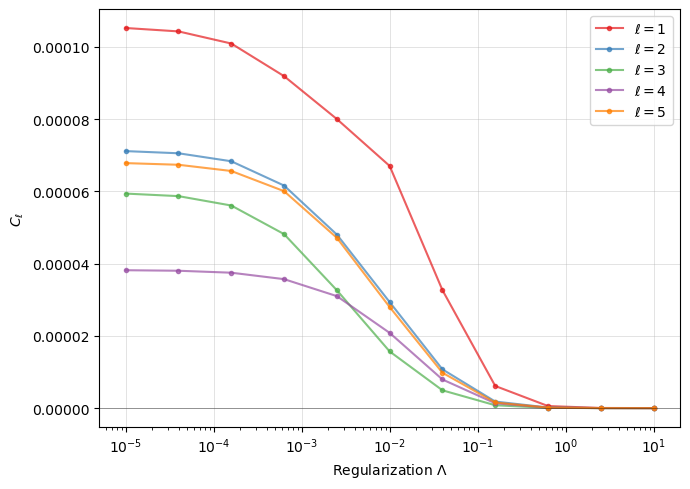

In [7]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
cs = list(map(mpl.cm.Set1, range(max_ell)))
for i, ell in enumerate(ells):
    ax.plot(Lambdas, Cells[:,i], marker='.', c=cs[i], alpha=0.7, label=r'$\ell=$'f'{ell}')
ax.grid(alpha=0.5, lw=0.5)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.semilogx()
ax.set_xlabel(r'Regularization $\Lambda$')
ax.set_ylabel(r'$C_\ell$')
ax.legend()

#### variance in the reconstructed map

In [8]:
# fit up to max ell and return the coefficients
max_ell = 1
_, _, alms_ = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map, Lambda=Lambdas[0],
                                                             max_ell=max_ell, selfunc=selfunc_quaia, return_alms=True)
reconstructed_map = multipoles.reconstruct_map(alms_)

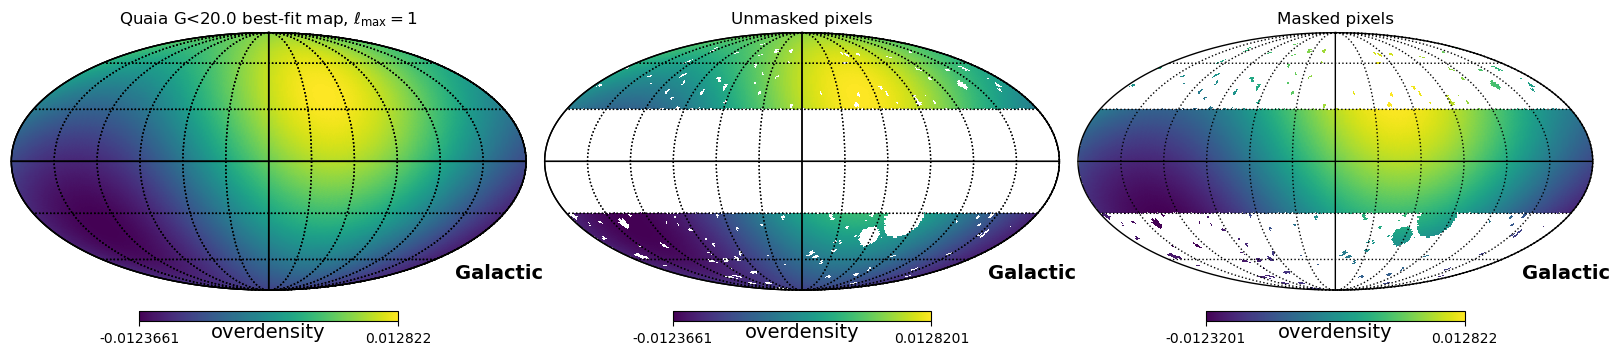

In [9]:
# plot
fig = plt.figure(figsize=(16,4))
hp.mollview(reconstructed_map, title=f'Quaia G<{d.maglim} best-fit map, 'r'$\ell_\mathrm{max}=$'f'{max_ell}',
            coord=['C','G'], unit='overdensity', badcolor='w', fig=fig, sub=(1,3,1))
hp.graticule()
unmasked_pix = reconstructed_map.copy()
unmasked_pix[~d.mask] = np.nan
hp.mollview(unmasked_pix, title=f'Unmasked pixels',
            coord=['C','G'], unit='overdensity', badcolor='w', fig=fig, sub=(1,3,2))
hp.graticule()
masked_pix = reconstructed_map.copy()
masked_pix[d.mask] = np.nan
hp.mollview(masked_pix, title=f'Masked pixels',
            coord=['C','G'], unit='overdensity', badcolor='w', fig=fig, sub=(1,3,3))
hp.graticule()

In [10]:
# variance in the unmasked vs masked pixels
np.nanvar(unmasked_pix), np.nanvar(masked_pix)

(5.6859755765275055e-05, 4.9203133832822154e-05)

In [11]:
# okay now for each Lambda, do the fit, and compare the variance in the masked vs unmasked pixels
var_unmasked = np.empty(len(Lambdas))
var_masked = np.empty_like(var_unmasked)
for i, Lambda in enumerate(Lambdas):
    _, _, alms = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map, Lambda=Lambda,
                                                             max_ell=max_ell, selfunc=selfunc_quaia, return_alms=True)
    reconstructed_map_ = multipoles.reconstruct_map(alms)
    var_unmasked[i] = np.nanvar(reconstructed_map_[np.where(d.mask)]) # since d.mask == 1 in the unmasked pixels
    var_masked[i] = np.nanvar(reconstructed_map_[np.where(~d.mask)])

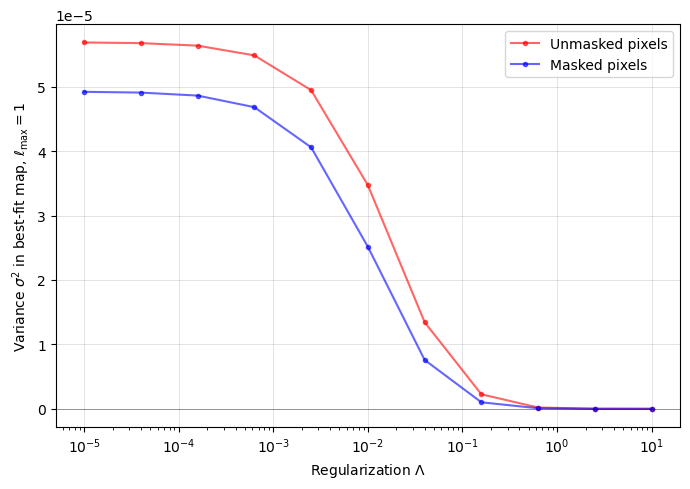

In [12]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(Lambdas, var_unmasked, marker='.', c='r', alpha=0.6, label='Unmasked pixels')
ax.plot(Lambdas, var_masked, marker='.', c='b', alpha=0.6, label='Masked pixels')
ax.grid(alpha=0.5, lw=0.5)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.semilogx()
ax.set_xlabel(r'Regularization $\Lambda$')
ax.set_ylabel(r'Variance $\sigma^2$ in best-fit map, $\ell_\mathrm{max}=$'f'{max_ell}')
ax.legend()

In [14]:
max_ells = np.arange(1, 5)
vars_unmasked = np.empty((len(max_ells),len(Lambdas)))
vars_masked = np.empty_like(vars_unmasked)
for i, max_ell in enumerate(max_ells):
    for j, Lambda in enumerate(Lambdas):
        print(i, j, end='\r')
        _, _, alms = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map, Lambda=Lambda,
                                                                 max_ell=max_ell, selfunc=selfunc_quaia, return_alms=True)
        reconstructed_map_ = multipoles.reconstruct_map(alms)
        vars_unmasked[i,j] = np.nanvar(reconstructed_map_[np.where(d.mask)]) # since d.mask == 1 in the unmasked pixels
        vars_masked[i,j] = np.nanvar(reconstructed_map_[np.where(~d.mask)])

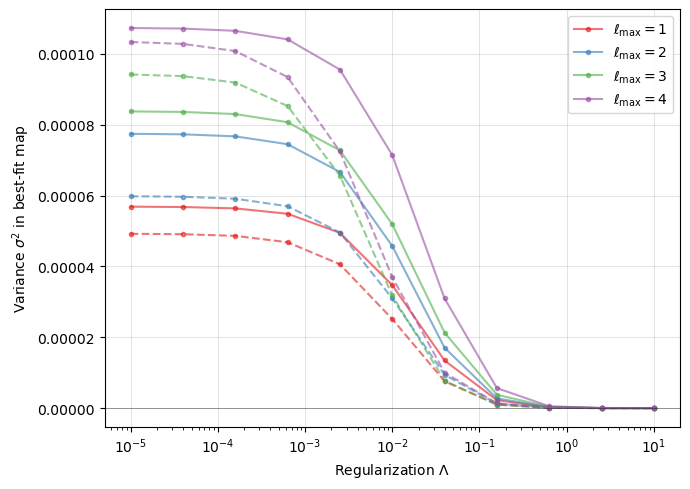

In [15]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
cs = list(map(mpl.cm.Set1, range(len(max_ells))))
for i, max_ell in enumerate(max_ells):
    kwargs = dict(marker='.', c=cs[i], alpha=0.6)
    ax.plot(Lambdas, vars_unmasked[i], label=r'$\ell_\mathrm{max}=$'f'{max_ell}', **kwargs) # label='Unmasked pixels', 
    ax.plot(Lambdas, vars_masked[i], ls='--', **kwargs) # label='Masked pixels', 
    
ax.grid(alpha=0.5, lw=0.5)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.semilogx()
ax.set_xlabel(r'Regularization $\Lambda$')
ax.set_ylabel(r'Variance $\sigma^2$ in best-fit map')
ax.legend()